In [1]:
!pip install -q langchain
!pip install -q chromadb
!pip install -q -U langchain langchain-openai
!pip install -q langchain_community
!pip install -q langchain_core langchain
!pip install -q fastembed
!pip install -q tiktoken
!pip install -q langchain_openai
!pip install -q umap-learn


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.4.1 requires cubinlinker, which is not installed.
cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.4.1 requires ptxcompiler, which is not installed.
cuml 24.4.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which is not installed.
keras-cv 0.9.0 requires keras-core, which is not installed.
keras-nlp 0.12.1 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 14.0.2 which is incompatible.
cud

In [2]:
import pandas as pd
import re

In [5]:
df = pd.read_csv("/kaggle/input/main-text/main_texts.csv")
df.head()

,Book_section,Cleaned Text
0,3GPP TS 38.161 Ruixin Wang 2022-08-26 03:21:00...,the trs requirements specified in clause apply...
1,3GPP TS 38.331 MCC Support 2024-01-15 08:42:00...,the ie olpcsrspos is used to convey olpc srs p...
2,3GPP TS 33.180 MCC Support 2024-03-14 08:13:00...,for each client in an external or unprotected ...
3,3GPP TS ab.cde MCC Support 2024-03-13 15:40:00...,ara the adae client and the adae server shall ...
4,3GPP TS ab.cde MCC Support 2022-11-22 09:07:00...,a data network access identifier dnai is an op...


In [6]:
text = df["Cleaned Text"]

In [7]:
text

0        the trs requirements specified in clause apply...
1        the ie olpcsrspos is used to convey olpc srs p...
2        for each client in an external or unprotected ...
3        ara the adae client and the adae server shall ...
4        a data network access identifier dnai is an op...
                               ...                        
99230    are available or the corresponding sldefaulttx...
99231    in this subclause the term interworking is use...
99232    table chsu parameter command syntax descriptio...
99233                                                 void
99234    the simple data types defined in table shall b...
Name: Cleaned Text, Length: 99235, dtype: object

In [8]:
import tiktoken

def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [9]:
text = text.astype(str)

In [10]:
counts = [num_tokens_from_string(t) for t in text]

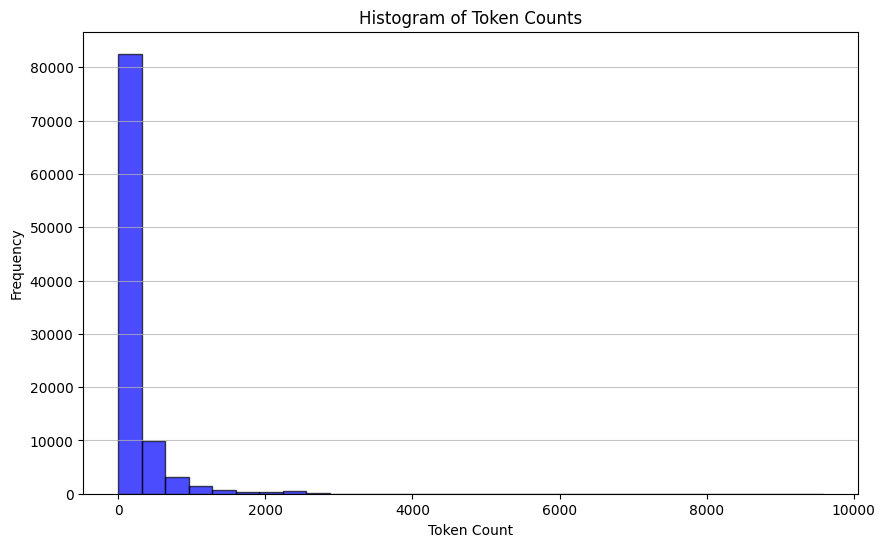

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()

In [12]:
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings
embeddings = FastEmbedEmbeddings(model_name="BAAI/bge-base-en-v1.5")

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model_optimized.onnx:   0%|          | 0.00/218M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/740 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

In [13]:
global_embeddings = [embeddings.embed_query(txt) for txt in text[:50]]

In [14]:
import matplotlib.pyplot as plt
from typing import Optional
import numpy as np
import umap

def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)
global_embeddings_reduced[0]

2024-07-04 22:18:00.624680: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 22:18:00.624809: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 22:18:00.763843: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


array([4.379477 , 3.9378693], dtype=float32)

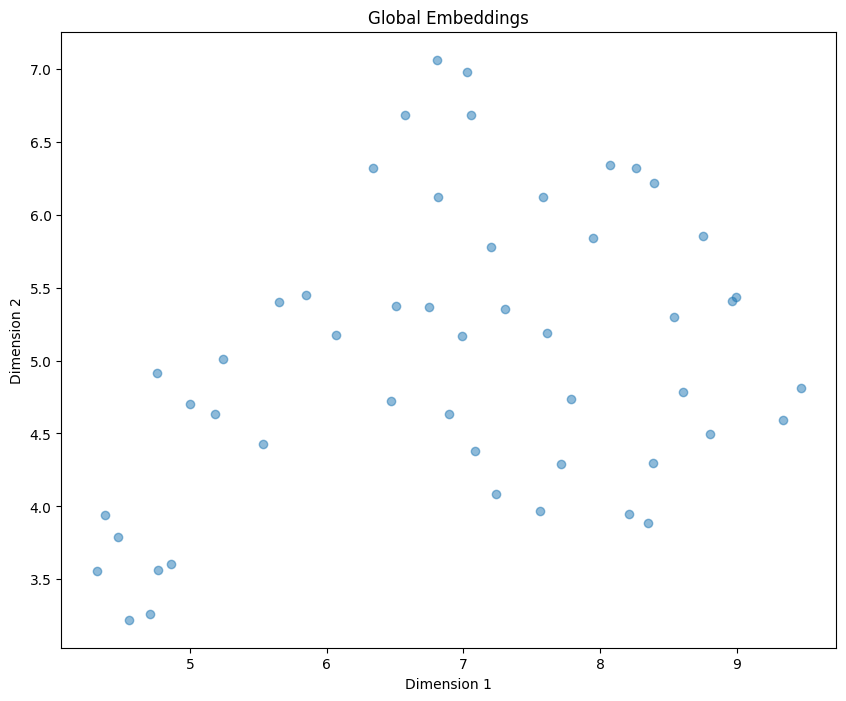

In [15]:
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

def get_optimal_clusters(embeddings: np.ndarray, max_clusters: int = 50, random_state: int = 1234):
    max_clusters = min(max_clusters, len(embeddings))
    bics = [GaussianMixture(n_components=n, random_state=random_state).fit(embeddings).bic(embeddings)
            for n in range(1, max_clusters)]
    return np.argmin(bics) + 1

def gmm_clustering(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state).fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters

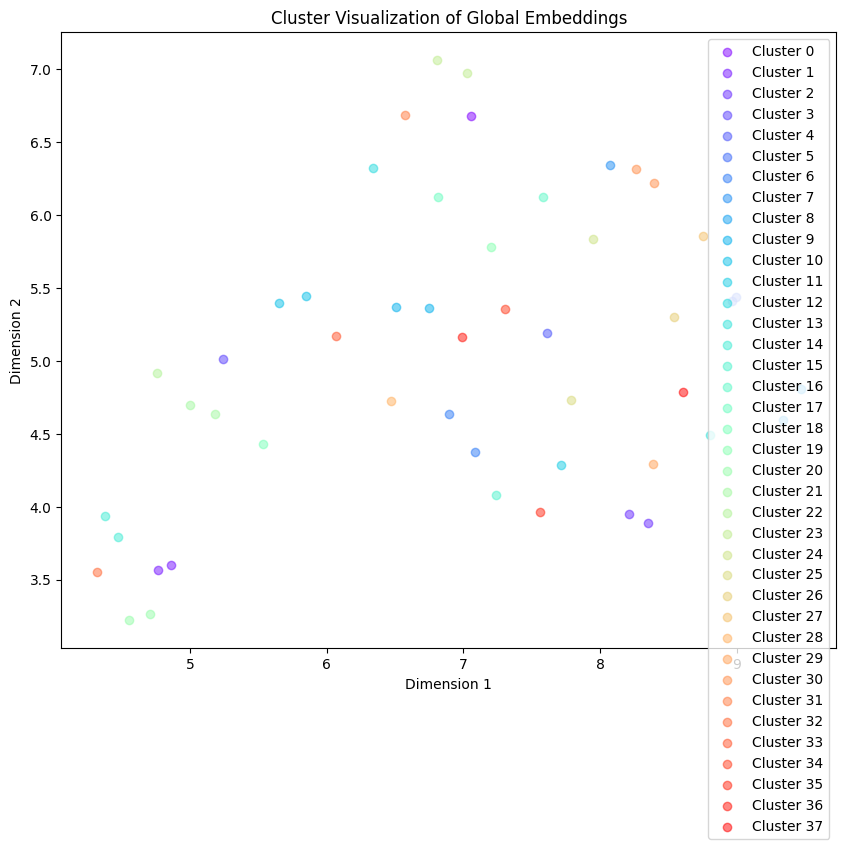

In [17]:
labels, _ = gmm_clustering(global_embeddings_reduced, threshold=0.5)

plot_labels = np.array([label[0] if len(label) > 0 else -1 for label in labels])
plt.figure(figsize=(10, 8))

unique_labels = np.unique(plot_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = plot_labels == label
    plt.scatter(global_embeddings_reduced[mask, 0], global_embeddings_reduced[mask, 1], color=color, label=f'Cluster {label}', alpha=0.5)

plt.title("Cluster Visualization of Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

In [18]:
import pandas as pd

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

df = pd.DataFrame({
    'Text': text[:50],
    'Embedding': list(global_embeddings_reduced),
    'Cluster': simple_labels
})
df.head()

,Text,Embedding,Cluster
0,the trs requirements specified in clause apply...,"[4.379477, 3.9378693]",14
1,the ie olpcsrspos is used to convey olpc srs p...,"[8.750655, 5.8572245]",27
2,for each client in an external or unprotected ...,"[6.7521725, 5.3653584]",9
3,ara the adae client and the adae server shall ...,"[7.0276747, 6.9757824]",23
4,a data network access identifier dnai is an op...,"[7.6100054, 5.1894608]",4


In [19]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Text'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

In [ ]:
clustered_texts = format_cluster_texts(df)
clustered_texts

In [21]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Falconsai/text_summarization")
model = AutoModelForSeq2SeqLM.from_pretrained("Falconsai/text_summarization")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [22]:
def summarize_text(text, prompt="Summarize the following text concisely:", max_length=100, min_length=10):
    # Combine prompt and text
    full_text = f"{prompt}\n\n{text}"

    inputs = tokenizer(full_text, return_tensors="pt", max_length=1000, truncation=True)

    summary_ids = model.generate(
        inputs["input_ids"],
        num_beams=4,
        max_length=max_length,
        min_length=min_length,
        length_penalty=2.0,
        early_stopping=True
    )

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

In [23]:
summaries = {}
for cluster, text in clustered_texts.items():
    try:
        summary = summarize_text(text)
        summaries[cluster] = summary
        print(f"Summarized cluster {cluster}")
    except Exception as e:
        print(f"Failed to summarize cluster {cluster}: {str(e)}")

Summarized cluster 14
Summarized cluster 27
Summarized cluster 9
Summarized cluster 23
Summarized cluster 4
Summarized cluster 32
Summarized cluster 8
Summarized cluster 25
Summarized cluster 24
Summarized cluster 10
Summarized cluster 2
Summarized cluster 35
Summarized cluster 22
Summarized cluster 3
Summarized cluster 7
Summarized cluster 21
Summarized cluster 13
Summarized cluster 6
Summarized cluster 26
Summarized cluster 18
Summarized cluster 33
Summarized cluster 1
Summarized cluster 15
Summarized cluster 17
Summarized cluster 20
Summarized cluster 37
Summarized cluster 11
Summarized cluster 29
Summarized cluster 34
Summarized cluster 5
Summarized cluster 31
Summarized cluster 30
Summarized cluster 36
Summarized cluster 0
Summarized cluster 19
Summarized cluster 28
Summarized cluster 16
Summarized cluster 12


In [24]:
summaries

{14: 'Summarize the following text concisely: the trs requirements specified in clause apply to handheld ue configured with maximum number of rx antennas supported for each band which is specified in ts clause the trs requirements defined in clause should be verified based on the detailed test parameters in table --- the minimum requirement applies per singleband connector supporting transmission in the operating band the minimum requirement for san type h is defined in ts',
 27: 'Summarize the following text concisely: The ie olpcsrspos is used to convey olpc srs positioning related parameters specific for a certain band olpcsrspos information element asnstart tagolpcsrsposstart olpcsrsposstart olpcsrsposstart olpcsrsposstart',
 9: 'Summarize the following text concisely: For each client in an external or unprotected mc system that uses the segys unenrypted interface the segy performs the security functions of an mc client on behalf of the external user as an external user is signalle

In [25]:
embedded_summaries = [embeddings.embed_query(summary) for summary in summaries.values()]

embedded_summaries_np = np.array(embedded_summaries)

labels, _ = gmm_clustering(embedded_summaries_np, threshold=0.5)

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

In [26]:
clustered_summaries = {}
for i, label in enumerate(simple_labels):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(list(summaries.values())[i])

In [27]:
clustered_summaries

{0: ['Summarize the following text concisely: the trs requirements specified in clause apply to handheld ue configured with maximum number of rx antennas supported for each band which is specified in ts clause the trs requirements defined in clause should be verified based on the detailed test parameters in table --- the minimum requirement applies per singleband connector supporting transmission in the operating band the minimum requirement for san type h is defined in ts',
  'Summarize the following text concisely: The ie olpcsrspos is used to convey olpc srs positioning related parameters specific for a certain band olpcsrspos information element asnstart tagolpcsrsposstart olpcsrsposstart olpcsrsposstart olpcsrsposstart',
  'Summarize the following text concisely: For each client in an external or unprotected mc system that uses the segys unenrypted interface the segy performs the security functions of an mc client on behalf of the external user as an external user is signalled fro

In [28]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = summarize_text(combined_text)
    final_summaries[cluster] = summary

In [29]:
final_summaries

{0: 'responses ref tscommondatayamlcomponentsresponses ref tscommondatayamlcomponentsresponses ref tscommondatayamlcomponentsresponses ref tscommondatayamlcomponentsresponses ref tscommondatayamlcomponentsresponses ref tscommondatayam'}

In [30]:
texts_from_df = df['Text'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

In [31]:
from langchain_community.vectorstores import Chroma

vectorstore = Chroma.from_texts(texts=combined_texts, embedding=embeddings)

In [32]:
def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while final_number < max_threshold:
        retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})
        docs = retriever.get_relevant_documents(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 1
        else:
            break
    return final_number

final_number = adjust_final_number("What is the purpose of the Nmfaf_3daDataManagement_Deconfigure service operation?", 10000, 4)

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [33]:
final_number

24

In [50]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

In [51]:
def remove_release_number(data: pd.DataFrame,
                          column: str) -> pd.DataFrame:

    data[column] = [re.findall('(.*?)(?:\s+\[3GPP Release \d+]|$)', x)[0] for x in data[column]]
    return data


def get_option_5(row: pd.Series) -> str:

    option_5 = row['option 5']
    if pd.isna(option_5):
        option_5 = ''
    else:
        option_5 = f'E) {option_5}'
    return option_5


def encode_answer(answer: str | int,
                  encode_letter: bool = True) -> int | str:

    letter_to_number = {'A': 1,
                        'B': 2,
                        'C': 3,
                        'D': 4,
                        'E': 5}
    if encode_letter:
        encoded = letter_to_number[answer]
    else:
        number_to_letter = {y: x for x, y in letter_to_number.items()}
        encoded = number_to_letter[answer]
    return encoded


def rag(row: pd.Series, query_eng) -> str:

    query = row['question']
    response = query_eng.invoke(query)
    context = 'Context:\n'
    context = context + " ".join([doc.page_content for doc in response]) + '\n'

    context = re.sub('\s+', ' ', context)
    return context


def generate_prompt(row: pd.Series,
                    context: str) -> str:
    prompt = f"""
    Provide a correct answer to a multiple choice question. Use only one option from A, B, C, D or E.
    {row['question']}
    A) {row['option 1']}
    B) {row['option 2']}
    C) {row['option 3']}
    D) {row['option 4']}
    {get_option_5(row)}
    {context}
    Answer:
    """
    return prompt

In [52]:
df = pd.read_json('/kaggle/input/rag-for-telecom-networks/TeleQnA_training.txt').T
df.head(3)

,question,option 1,option 2,option 3,option 4,answer,explanation,category,option 5
question 0,What is the purpose of the Nmfaf_3daDataManage...,To configure the MFAF to map data or analytics...,To configure the MFAF to stop mapping data or ...,To supply data or analytics from the MFAF to n...,To fetch data or analytics from the MFAF based...,option 2: To configure the MFAF to stop mappin...,The Nmfaf_3daDataManagement_Deconfigure servic...,Standards specifications,NaN
question 4,How does a supporting UE attach to the same co...,It requests the core network node to remember ...,It uses information stored in the UE when it w...,It relies on the SIM/USIM card for information.,It performs a fresh attach procedure.,option 2: It uses information stored in the UE...,A supporting UE in a shared network attaches t...,Standards specifications,NaN
question 11,When can the setting of the Privacy exception ...,Never,Only during emergency services,Anytime,Only with operator permission,option 3: Anytime,The setting of the Privacy exception list can ...,Standards specifications,NaN


In [53]:
from tqdm import tqdm

In [74]:
import torch
import re
import pandas as pd
from tqdm import tqdm

def llm_inference(data: pd.DataFrame,
                  model,
                  tokenizer,
                  retriever,
                  store_wrong: bool = False) -> tuple[pd.DataFrame, list]:
    # Convert model to full precision
    model = model.float()
    
    answers = []
    wrong_format = []
    for _, question in tqdm(data.iterrows()):
        prompt_context = rag(question, retriever)
        prompt = generate_prompt(question, prompt_context)
        print(f"\n{question['Question_ID']}")
        print(prompt)
        inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=False)
        
        # Move inputs to the same device as the model
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
        # Generate only one new character. It should be our answer
        outputs = model.generate(**inputs, max_length=inputs['input_ids'].size(1)+1, pad_token_id=tokenizer.eos_token_id)
        answer_letter = tokenizer.batch_decode(outputs)[0][len(prompt):len(prompt)+1]
        try:
            answer = encode_answer(answer_letter)
            print("....", answer)
        except:
            try:
                print(f"Question {question['Question_ID']} output was improper ({answer_letter})! Checking if it wasn't because of spaces...")
                outputs = model.generate(**inputs, max_length=inputs['input_ids'].size(1)+4, pad_token_id=tokenizer.eos_token_id)
                print(f'Full output:\n{tokenizer.batch_decode(outputs)[0]}')
                answer_letter = tokenizer.batch_decode(outputs)[0][len(prompt)-5:len(prompt)+5]
                answer_letter = re.findall('(A|B|C|D|E)\)', answer_letter)[0]
                answer = encode_answer(answer_letter)
                print(f'New answer: {answer}')
            except:
                print(f"Question {question['Question_ID']} output was improper ({answer_letter})! Changing answer to 1")
                answer = 1
                outputs = model.generate(**inputs, max_length=inputs['input_ids'].size(1)+20, pad_token_id=tokenizer.eos_token_id)
                answer_letter = tokenizer.batch_decode(outputs)[0]
                print(answer_letter)
                if store_wrong:
                    wrong_format.append([question['Question_ID'], answer_letter])
        answers.append([question['Question_ID'], answer])
    
    answers = pd.DataFrame(answers, columns=['Question_ID', 'Answer_ID'])
    return answers, wrong_format


In [73]:
results_train

,Question_ID,Answer_ID
0,0,1
1,4,1
2,11,3
3,12,4
4,14,2


In [40]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model_path = 'microsoft/phi-2'
model = AutoModelForCausalLM.from_pretrained(model_path,
                                             torch_dtype="auto",
                                             trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained('microsoft/phi-2',
                                          trust_remote_code=True)

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [55]:
df['Question_ID'] = df.index.str.split(' ').str[-1]
df = remove_release_number(df, 'question')

In [56]:
df.head(3)

,question,option 1,option 2,option 3,option 4,answer,explanation,category,option 5,Question_ID
question 0,What is the purpose of the Nmfaf_3daDataManage...,To configure the MFAF to map data or analytics...,To configure the MFAF to stop mapping data or ...,To supply data or analytics from the MFAF to n...,To fetch data or analytics from the MFAF based...,option 2: To configure the MFAF to stop mappin...,The Nmfaf_3daDataManagement_Deconfigure servic...,Standards specifications,NaN,0
question 4,How does a supporting UE attach to the same co...,It requests the core network node to remember ...,It uses information stored in the UE when it w...,It relies on the SIM/USIM card for information.,It performs a fresh attach procedure.,option 2: It uses information stored in the UE...,A supporting UE in a shared network attaches t...,Standards specifications,NaN,4
question 11,When can the setting of the Privacy exception ...,Never,Only during emergency services,Anytime,Only with operator permission,option 3: Anytime,The setting of the Privacy exception list can ...,Standards specifications,NaN,11


In [ ]:
# Run the inference
results_train, _ = llm_inference(df.iloc[:5], model, tokenizer, retriever)